In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import Optional, Sequence
from pathlib import Path
from collections import defaultdict

import numpy as np
from scipy.spatial.distance import pdist, cdist
from scipy.stats import pearsonr, spearmanr, wasserstein_distance

from matplotlib import pyplot as plt
import matplotlib

import torch
import mlflow

from popari import tl, pl
# from popari.model import load_trained_model
from popari.components import PopariDataset

In [4]:
import scanpy as sc
sc._settings.settings._vector_friendly = True

In [5]:
# Save PDF text as text
matplotlib.rcParams['pdf.fonttype'] = 42

In [6]:
from popari._simulation_utils import spatial_wasserstein, all_pairs_spatial_wasserstein
from popari._dataset_utils import _compute_empirical_correlations

In [7]:
def _evaluate_ground_truth(dataset, real_metagene_index: Optional[Sequence[int]] = None,
                           embedding_truth_key: str = "ground_truth_X",
                           metagene_truth_key: str = "ground_truth_M"
                          ):
    """Evaluate learned metagenes/embeddings.

    Assumes that ground truth metagenes and embeddings are available.
    
    Args:
        hello
    """
   
    
    if real_metagene_index is None:
        real_metagene_index = slice(None)
    
    coordinates = dataset.obsm["spatial"]
    true_embeddings = dataset.obsm[embedding_truth_key].T
    true_metagenes = dataset.uns[metagene_truth_key][dataset.name].T
    learned_embeddings = dataset.obsm["X"].T
    learned_metagenes = dataset.uns["M"][dataset.name].T
    

    def pearson_correlation_magnitude(x, y):
        return abs(pearsonr(x,y)[0])

    def normalized_wasserstein_distance(x, y):
        return wasserstein_distance(x/x.sum(), y/y.sum())
                   
    embedding_pearson_correlations = cdist(true_embeddings, learned_embeddings, metric=pearson_correlation_magnitude)
    metagene_pearson_correlations = cdist(true_metagenes, learned_metagenes, metric=pearson_correlation_magnitude)
    embedding_wasserstein = cdist(true_embeddings, learned_embeddings, metric=normalized_wasserstein_distance)
    metagene_wasserstein = cdist(true_metagenes, learned_metagenes, metric=normalized_wasserstein_distance)
    
#     embedding_spatial_wasserstein = cdist(dataset.obsm[embedding_truth_key].T, dataset.obsm["X"].T, metric=lambda x,y: spatial_wasserstein(coordinates, x, y))
    embedding_spatial_wasserstein = all_pairs_spatial_wasserstein(dataset)    

#     assert np.all(dataset.obsm[embedding_truth_key].T.sum(axis=1) > 0), np.where(dataset.obsm[embedding_truth_key].T.sum(axis=1) ==0)
#     assert np.all(dataset.obsm["X"].T.sum(axis=1) > 0), np.where(dataset.obsm["M"].T.sum(axis=1) == 0)

    dataset.uns["embedding_pearson_correlations"] = embedding_pearson_correlations
    dataset.uns["metagene_pearson_correlations"] = metagene_pearson_correlations    
    dataset.uns["embedding_wasserstein"] = embedding_wasserstein
    dataset.uns["metagene_wasserstein"] = metagene_wasserstein
    dataset.uns["embedding_spatial_wasserstein"] = embedding_spatial_wasserstein
    
            
    metagene_pearson_minmax = metagene_pearson_correlations.max(axis=1)[real_metagene_index].min()
    embedding_pearson_minmax = np.nanmax(embedding_pearson_correlations[real_metagene_index], axis=1).min()
    metagene_wasserstein_maxmin = metagene_wasserstein.min(axis=1)[real_metagene_index].max()
    embedding_wasserstein_maxmin = np.nanmin(embedding_wasserstein[real_metagene_index], axis=1).max()
    
    dataset.uns["metagene_pearson_minmax"] = metagene_pearson_minmax
    dataset.uns["embedding_pearson_minmax"] = metagene_pearson_minmax
    dataset.uns["metagene_wasserstein_maxmin"] = metagene_wasserstein_maxmin
    assert not np.isnan(embedding_wasserstein_maxmin), np.where(true_embeddings.sum(axis=1) ==0)
    
    dataset.uns["embedding_wasserstein_maxmin"] = embedding_wasserstein_maxmin

    embedding_spatial_wasserstein_maxmin = np.nanmin(embedding_spatial_wasserstein[real_metagene_index], axis=1).max()
    embedding_spatial_wasserstein_avgmin = np.min(embedding_spatial_wasserstein[real_metagene_index], axis=1).mean()
    
    dataset.uns["embedding_spatial_wasserstein_maxmin"] = embedding_spatial_wasserstein_maxmin
    dataset.uns["embedding_spatial_wasserstein_avgmin"] = embedding_spatial_wasserstein_avgmin

In [8]:
def _evaluate_model(model, metagene_indices, is_spatial):
    """Evaluate metrics for every level of hierarchical model.
    
    """

    propagate_ground_truth(model)

    dataset_lists = [view.datasets for view in model.hierarchy.values()]
    
    for datasets in dataset_lists:
        if is_spatial:
            _compute_empirical_correlations(datasets, scaling=10) 
            _compute_empirical_correlations(datasets, feature="ground_truth_X", output="ground_truth_correlation", scaling=10)    
    
        for dataset, metagene_index in zip(datasets, metagene_indices):
            _evaluate_ground_truth(dataset, real_metagene_index=metagene_index)
            if is_spatial:
                _compute_affinity_coherence(dataset)
                _compute_affinity_correlation(dataset, real_metagene_index=metagene_index)

In [9]:
def propagate_ground_truth(model, embedding_truth_key = "ground_truth_X", metagene_truth_key = "ground_truth_M"):
    """Propagate ground truth embeddings and metagenes to lower levels of hierarchy.
    
    """
    for level in range(model.hierarchical_levels-1):
        view = model.hierarchy[level]

        for dataset, low_res_dataset in zip(view.datasets, view.low_res_view.datasets):
            true_embeddings = dataset.obsm[embedding_truth_key]
            true_metagenes = dataset.uns[metagene_truth_key][dataset.name].copy()
            
            low_res_dataset.obsm[embedding_truth_key] = low_res_dataset.obsm[f"bin_assignments_{dataset.name}_level_{level+1}"] @ true_embeddings
            low_res_dataset.uns[metagene_truth_key] = {low_res_dataset.name: true_metagenes}

In [10]:
from scipy.optimize import linear_sum_assignment

def _compute_affinity_correlation(dataset: PopariDataset,
                                  embedding_truth_key = "ground_truth_X",
                                  metagene_truth_key = "ground_truth_M",
                                  embedding_key = "X",
                                  metagene_key = "M",
                                  spatial_affinity_key = "Sigma_x_inv",
                                  correlation_truth_key = "ground_truth_correlation",
                                  real_metagene_index=None):
    
    """Compute Pearson correlation of spatial affinities with ground truth spatial correlation.
    
    """
    
    Sigma_x_inv = dataset.uns[spatial_affinity_key][dataset.name]
    empirical_correlation = dataset.uns[correlation_truth_key][dataset.name][real_metagene_index][:, real_metagene_index]
    
    K_dataset = len(real_metagene_index)
    
    # embedding_pearson_correlations = cdist(dataset.obsm[embedding_truth_key].T, dataset.obsm[embedding_key].T, metric=lambda x,y: abs(pearsonr(x,y)[0]))
    # embedding_pearson_argmaxes = embedding_pearson_correlations[real_metagene_index].argmax(axis=1)

    embedding_spatial_wasserstein = dataset.uns["embedding_spatial_wasserstein"][real_metagene_index]

    embedding_spatial_wasserstein_argmins = embedding_spatial_wasserstein.argmin(axis=1)
    # embedding_pearson_argmaxes = embedding_pearson_correlations[real_metagene_index].argmax(axis=1)
    
    _, matched_indices = linear_sum_assignment(embedding_spatial_wasserstein)

    permuted_Sigma_x_inv = Sigma_x_inv[matched_indices, :][:, matched_indices]
    
    #pearson = pearsonr(empirical_correlation.flatten(), permuted_Sigma_x_inv.flatten())[0]
    pearson = spearmanr(empirical_correlation.flatten(), permuted_Sigma_x_inv.flatten())[0]
    dataset.uns["affinity_correlation"] = np.nan_to_num(pearson)

    dataset.uns["permuted_Sigma_x_inv"] = {
        dataset.name: permuted_Sigma_x_inv
    }

    dataset.uns["matched_indices"] = matched_indices
    dataset.obsm["truncated_ground_truth_X"] = dataset.obsm[embedding_truth_key][:, real_metagene_index]
    dataset.obsm["truncated_matched_X"] = dataset.obsm[embedding_key][:, matched_indices]
    
def _compute_affinity_coherence(dataset: PopariDataset,
                                spatial_affinity_key = "Sigma_x_inv",
                                empirical_correlation_key = "empirical_correlation",
                                ):
    """Compute Pearson correlation of spatial affinities with in-situ spatial correlation.
    
    """
    empirical_correlation = dataset.uns[empirical_correlation_key][dataset.name]
    
    empirical_correlation = empirical_correlation.copy()
    empirical_correlation /= np.abs(empirical_correlation).max()
    Sigma_x_inv = dataset.uns[spatial_affinity_key][dataset.name].copy()
    Sigma_x_inv /= np.abs(Sigma_x_inv).max()
    
    pearson = pearsonr(empirical_correlation.flatten(), Sigma_x_inv.flatten())[0]
    
    dataset.uns["affinity_coherence"] = pearson

# Load MLflow run information

In [11]:
root_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/mlflow_experiments/joint_improvement_simulation/mlruns/")
mlflow.set_tracking_uri(root_directory)
client = mlflow.tracking.MlflowClient(tracking_uri=str(root_directory))

In [13]:
experiment_id = '0'

# parent_run_ids = ('bbb1c7e4560144a492c202970257f531', 'ffc72a1f6ef44090bdf662d9c4d2750d')
# parent_run_ids = ('510c8ef6e5f2499788406af513406c81', '7f25f5866a4e42cfb4780bf9b2a3a3ca')
# parent_run_ids = ('b2f2ca98c6d341969b35c59b5e800503')
# parent_run_ids = ('5d3438393e2f4ed4beb05da17601d574') # Differential hierarchical migration
# parent_run_ids = ('802ad5e45a7e43f1b6e681e7253af01a') # Simplified differential simulation
parent_run_ids = ('a0550484591d4a1983bbc0cdf6179add', '368955a12728404b8044a6e0697e5efc') # Joint improvement simulation
# parent_run_ids = ('894fef8ead934a2fa647dd07d154fb74', 'fc91be2ab27c40e191b163596b434891', '560e9452345740f5a227a87399fe49cc')

In [14]:
runs = client.search_runs(
    [experiment_id],
#             f"tags.mlflow.parentRunId = '{nmf_parent.info.run_id}' ",
)

In [15]:
filtered_runs = []
for index, run in enumerate(runs):
    parent_run = mlflow.get_parent_run(run.info.run_id)
    if parent_run and parent_run.info.run_id in parent_run_ids and run.data.params["nmf_preiterations"] !='0':
        filtered_runs.append(run)

In [16]:
# Sort runs
# TODO: just add tags to runs so that it's easier

nmf_vanilla_runs = []
spicemix_disjoint_runs = []
spicemix_vanilla_runs = []
popari_vanilla_runs = []

for run in filtered_runs:
    if run.data.tags.get("disjoint_metagenes", None) == "True":
        spicemix_disjoint_runs.append(run)
        
    elif run.data.params['num_iterations'] == '0':
        if run.data.params['spatial_preiterations'] == '0':
            nmf_vanilla_runs.append(run)
        else:
            spicemix_vanilla_runs.append(run)
    else:   
        popari_vanilla_runs.append(run)

In [17]:
print(f"""
Number of vanilla NMF runs: {len(nmf_vanilla_runs)}
Number of vanilla SpiceMix runs: {len(spicemix_vanilla_runs)}
Number of disjoint SpiceMix runs: {len(spicemix_disjoint_runs)}
Number of vanilla Popari runs: {len(popari_vanilla_runs)}
""")


Number of vanilla NMF runs: 100
Number of vanilla SpiceMix runs: 100
Number of disjoint SpiceMix runs: 100
Number of vanilla Popari runs: 100



# Compute metrics

In [18]:
from collections import defaultdict
from popari.mlflow.util import load_from_mlflow_run

class NestedDefaultDict(defaultdict):
    def __init__(self, type_constructor, levels=1):
        """Nested extension of defaultdict.
        
        Useful for storing structured data.
        """
        if levels == 1:
            super().__init__(type_constructor)
        elif levels > 1:
            super().__init__(lambda: NestedDefaultDict(type_constructor, levels=levels-1))

In [19]:
import json

class ModelEvaluation(object):
    """Evaluation of a matrix factorization-based model on a dataset.
    
    """

    def __init__(self,
            model_name,
            runs,
            mlflow_client,
            is_spatial: bool,
            filepath: Optional[str] = None,
            device: str = "cuda:0"
        ):
        
        self.model_name = model_name
        self.runs = runs
        self.is_computed = np.full(len(runs), False)
        self.device = device
        self.client = mlflow_client
        self.is_spatial = is_spatial

        if filepath is not None:
            with open(filepath, "r") as f:
                scores = json.load(f)
                self.scores = {int(key): value for (key, value) in scores.items()}
        else:
            self.scores = NestedDefaultDict(list, levels=3)
            

    def compute_metrics(self, metagene_indices, metric_names: Optional[Sequence[str]] = None):
        """Compute metric values to evaluate performance of this class of models.
        
        """
        if metric_names is None:
            metric_names = [
                "metagene_pearson_minmax",
                "embedding_pearson_minmax",
                "metagene_wasserstein_maxmin",
                "embedding_wasserstein_maxmin",
                "embedding_spatial_wasserstein_maxmin"
            ]
            if self.is_spatial:
                metric_names.extend([
                    "affinity_correlation",
                    "affinity_coherence"
                ])
                
        for index, run in enumerate(self.runs):
            if self.is_computed[index]:
                continue

            replicate_number = run.data.params["dataset_path"]
            
            model = load_from_mlflow_run(
                run,
                self.client,
                context=dict(device=self.device, dtype=torch.float64),
                verbose=1
            )

            _evaluate_model(model, metagene_indices, is_spatial=self.is_spatial)

            dataset_lists = [(level, view.datasets) for (level, view) in model.hierarchy.items()]
            
            for level in range(model.hierarchical_levels):
                datasets = model.hierarchy[level].datasets
                
                print(f"Computing level {level} metrics...")

                for metric in metric_names:
                    all_scores = [dataset.uns[metric] for dataset in datasets]
                    self.scores[level][metric][replicate_number].append(all_scores)

            self.is_computed[index] = True

    def save(self, filepath):
        with open(filepath, "w") as f:
            json.dump(self.scores, f)

In [20]:
num_fovs = 10
total_metagenes = 11
metagene_indices = [np.arange(total_metagenes) for _ in range(num_fovs)]

## Compute metrics from scratch

In [17]:
popari_evaluation = ModelEvaluation("Popari", popari_vanilla_runs, client, is_spatial=True)
nmf_evaluation = ModelEvaluation("NMF", nmf_vanilla_runs, client, is_spatial=False)
disjoint_spicemix_evaluation = ModelEvaluation("SpiceMix-D", spicemix_disjoint_runs, client, is_spatial=True)
joint_spicemix_evaluation = ModelEvaluation("SpiceMix-J", spicemix_vanilla_runs, client, is_spatial=True)

In [ ]:
popari_evaluation.compute_metrics(metagene_indices)
nmf_evaluation.compute_metrics(metagene_indices)
disjoint_spicemix_evaluation.compute_metrics(metagene_indices)
joint_spicemix_evaluation.compute_metrics(metagene_indices)

In [23]:
with open(root_directory / ".." / "nmf_evaluation.json", "w") as f:
    json.dump(nmf_evaluation.scores, f)

with open(root_directory / ".." / "disjoint_spicemix_evaluation.json", "w") as f:
    json.dump(disjoint_spicemix_evaluation.scores, f)

with open(root_directory / ".." / "joint_spicemix_evaluation.json", "w") as f:
    json.dump(joint_spicemix_evaluation.scores, f)

with open(root_directory / ".." / "popari_evaluation.json", "w") as f:
    json.dump(popari_evaluation.scores, f)

## Alternatively, load from disk

In [21]:
popari_evaluation = ModelEvaluation("Popari", popari_vanilla_runs, client, filepath=root_directory / ".." / "popari_evaluation.json", is_spatial=True)
nmf_evaluation = ModelEvaluation("NMF", nmf_vanilla_runs, client, filepath=root_directory / ".." / "nmf_evaluation.json", is_spatial=False)
disjoint_spicemix_evaluation = ModelEvaluation("SpiceMix-D", spicemix_disjoint_runs, client, filepath=root_directory / ".." / "disjoint_spicemix_evaluation.json", is_spatial=True)
joint_spicemix_evaluation = ModelEvaluation("SpiceMix-J", spicemix_vanilla_runs, client, filepath=root_directory / ".." / "joint_spicemix_evaluation.json", is_spatial=True)

# Plot figures

In [23]:
def _plot_pairwise_comparison(primary_evaluation,
                              other_evaluations,
                              general_metrics,
                              spatial_metrics,
                              reduction: str = "average",
                              level=0):
    """
    """

    general_metric_names, general_metric_directions = zip(*general_metrics)
    spatial_metric_names, spatial_metric_directions = zip(*spatial_metrics)
    metrics = [*general_metric_names, *spatial_metric_names]
    directions = [*general_metric_directions, *spatial_metric_directions]
    
    overall_fig = plt.figure(constrained_layout=True, dpi=600)
        
    subfigs = overall_fig.subfigures(nrows=len(metrics), ncols=1)

    # overall_fig = plt.figure(constrained_layout=True)
    # overall_fig.suptitle('Figure title')
    
    # # create 3x1 subfigs
    # subfigs = overall_fig.subfigures(nrows=3, ncols=1)


    # fig, axes = plt.subplots(len(metrics), len(other_evaluations), squeeze=False, tight_layout=True, dpi=600)

    for metric_index, (metric, direction) in enumerate(zip(metrics, directions)):
        # ax_row = axes[metric_index]
        
        ax_row = subfigs[metric_index].subplots(nrows=1, ncols=len(other_evaluations), squeeze=False)
        subfigs[metric_index].suptitle(f'{metric}')
        subfigs[metric_index].supxlabel(f'Popari')
        for evaluation_index, (other_evaluation, ax) in enumerate(zip(other_evaluations, ax_row.flat)):
            if metric_index >= len(general_metrics) and not other_evaluation.is_spatial:
                ax.set_axis_off()
                continue
                
            primary_scores = primary_evaluation.scores[level][metric]
            other_scores = other_evaluation.scores[level][metric]

            primary_scores = np.array([scores for replicate_name, scores in primary_scores.items()])
            other_scores = np.array([scores for replicate_name, scores in other_scores.items()])


            # Take the average score across all replicates
            primary_scores = primary_scores.mean(axis=-1)
            other_scores = other_scores.mean(axis=-1)

            # Pick the best random seed for each dataset
            reduction = np.max if direction == "larger" else np.min

            primary_scores = reduction(primary_scores, axis=-1)
            other_scores = reduction(other_scores, axis=-1)
            
            all_scores = [*primary_scores, *other_scores]
            score_ptp = np.ptp(all_scores)
            max_score = np.max([*primary_scores, *other_scores])
            max_score += 0.05 * score_ptp
            
            min_score = np.min([*primary_scores, *other_scores])
            min_score -= 0.05 * score_ptp

            domain = np.linspace(min_score, max_score, 50)
            boundary = np.zeros(len(domain)) if direction == "larger" else np.full(len(domain), max_score)
            
            # Draw desirable region            
            ax.fill_between(domain, domain, boundary, color="green", alpha=0.25, linewidth=0)
            
            ax.scatter(
                primary_scores.flatten(),
                other_scores.flatten(),
                edgecolors='none',
                alpha=0.75,
                s=10,
                c="black"
            )

            # ax.set_xlabel(primary_evaluation.model_name)
            ax.set_ylabel(other_evaluation.model_name)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlim([min_score, max_score])
            ax.set_ylim([min_score, max_score])

    return overall_fig

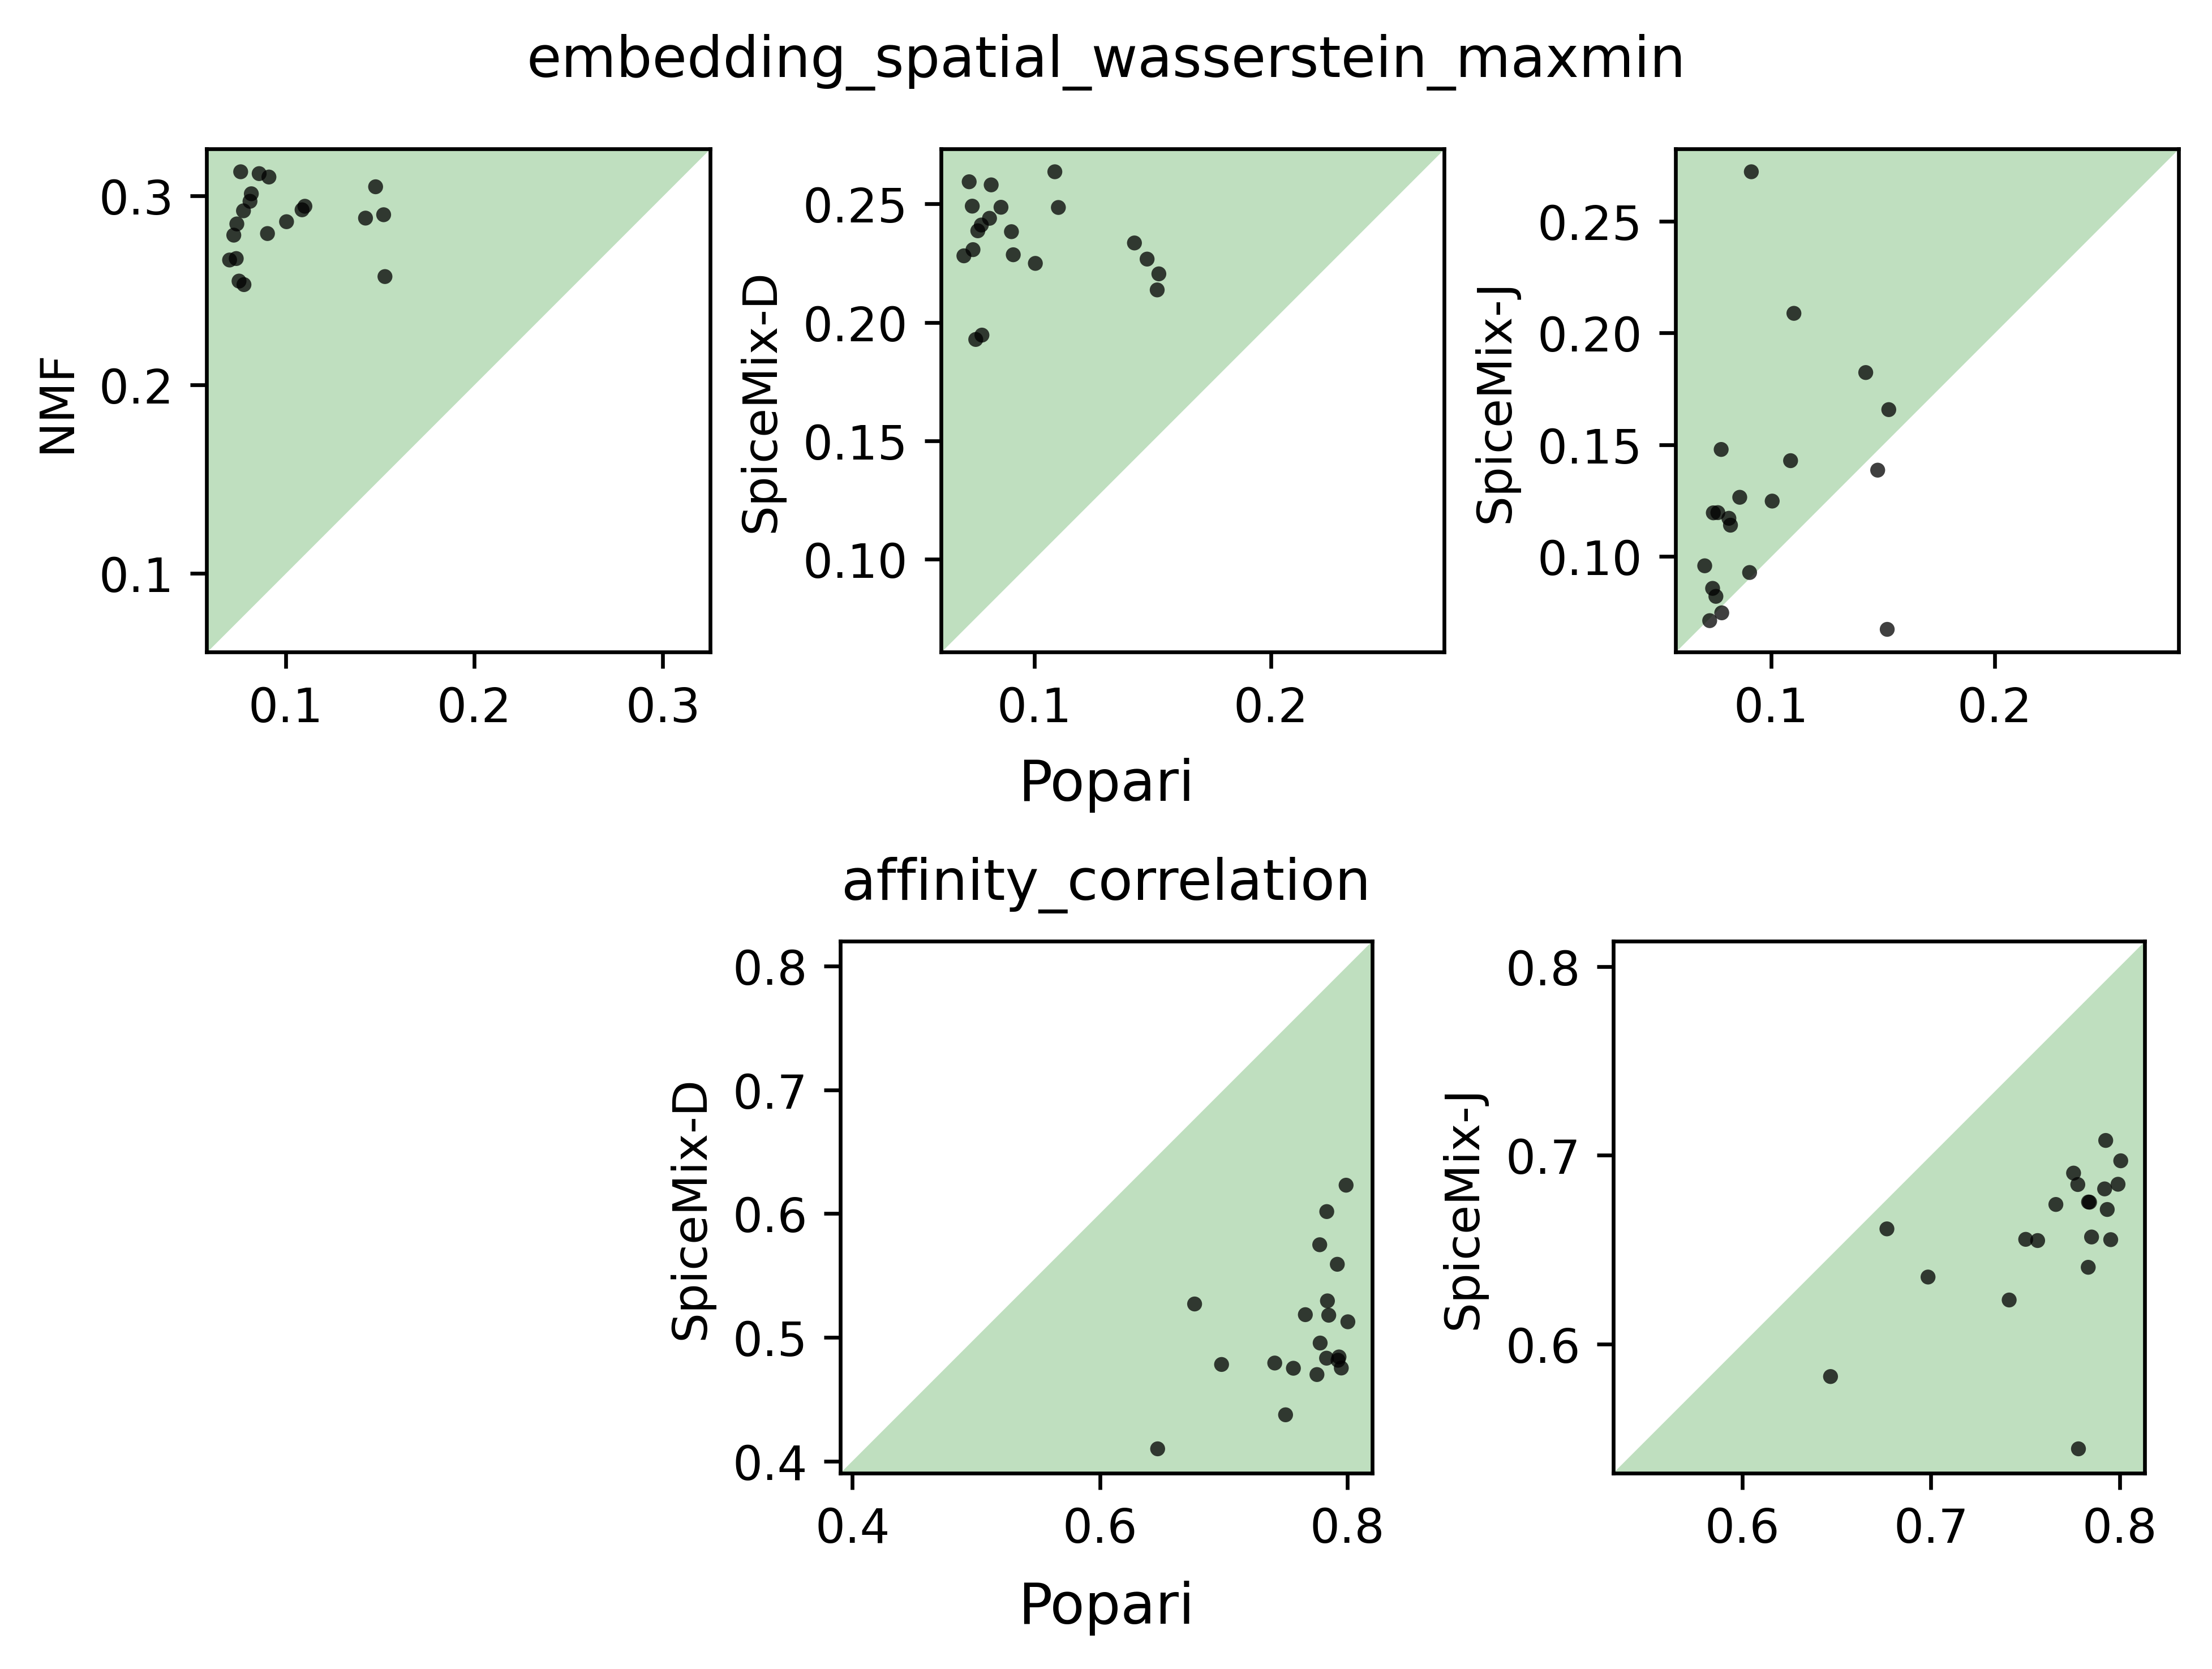

In [24]:
pairwise_comparison_fig = _plot_pairwise_comparison(popari_evaluation,
                          [nmf_evaluation, disjoint_spicemix_evaluation, joint_spicemix_evaluation],
                          general_metrics=[
                              ("embedding_spatial_wasserstein_maxmin", "smaller")
                          ],
                          spatial_metrics=[
                              ("affinity_correlation", "larger"),
                          ]
)

In [12]:
from pathlib import Path

figure_directory = Path(root_directory / ".." / "figures")
figure_directory.mkdir(exist_ok=True)

In [26]:
pairwise_comparison_fig.savefig(figure_directory / "joint_comparison.pdf", transparent=True)

In [27]:
import re
from popari._dataset_utils import _plot_all_embeddings

def _plot_best_in_situ_result(primary_evaluation,
                              other_evaluations,
                              metagene_indices,
                              metric,
                              dataset_index=0,
                              best_models=None,
                              size=None,
                              level=0):
    """
    """
    
    if best_models is None:
        best_models = {}
        
    overall_fig = plt.figure(constrained_layout=True, figsize=(10, 8), dpi=600) 
    subfigs = overall_fig.subfigures(nrows=len(other_evaluations) + 2, ncols=1)

    all_differences = []
    for evaluation_index, other_evaluation  in enumerate(other_evaluations):
        primary_scores = primary_evaluation.scores[level][metric]
        other_scores = other_evaluation.scores[level][metric]

        primary_scores = np.array([scores for replicate_name, scores in primary_scores.items()])
        other_scores = np.array([scores for replicate_name, scores in other_scores.items()])

        # Take the average score across all replicates
        primary_scores = primary_scores.mean(axis=-1)
        other_scores = other_scores.mean(axis=-1)
        
        all_differences.append(np.abs(primary_scores - other_scores))

    summed_differences = np.sum(all_differences, axis=0)
    
    best_index = np.unravel_index(np.argmax(summed_differences), summed_differences.shape)

    print(best_index)
    
    pattern = re.compile('random_state_[0-9]+')

    def find_matching_run(evaluation, best_replicate, best_state):
        print(len(evaluation.runs))
        for run in evaluation.runs:
            matching = pattern.findall(run.data.params["dataset_path"])[0]
            print(matching)
            replicate = int(matching.split("_")[-1])
            random_state = int(run.data.params["random_state"])
            if (replicate, random_state) == (best_replicate, best_state):
                return run

    # Load best primary_model
    best_primary_run = find_matching_run(primary_evaluation, *best_index)
    if "primary" not in best_models:
            
        best_primary_model = load_from_mlflow_run(
                    best_primary_run,
                    primary_evaluation.client,
                    context=dict(device=primary_evaluation.device, dtype=torch.float64),
                    verbose=1
        )
        _evaluate_model(best_primary_model, metagene_indices, is_spatial=primary_evaluation.is_spatial)
    else:
        best_primary_model = best_models["primary"]
         
    first_row = subfigs[0].subplots(nrows=1, ncols=best_primary_model.K, squeeze=True)
    _plot_all_embeddings(best_primary_model.hierarchy[level].datasets[dataset_index], fig=subfigs[0], embedding_key="truncated_ground_truth_X", ax=first_row, colorbar=False,cmap='Reds',  edgecolors='none', size=size)
    
    second_row = subfigs[1].subplots(nrows=1, ncols=best_primary_model.K, squeeze=True)
    _plot_all_embeddings(best_primary_model.hierarchy[level].datasets[dataset_index], fig=subfigs[0], embedding_key="truncated_matched_X", ax=second_row, colorbar=False, cmap='Reds', edgecolors='none', size=size)

    dataset = best_primary_model.hierarchy[level].datasets[dataset_index]
    for value, ax in zip(dataset.uns["embedding_spatial_wasserstein"][metagene_indices[dataset_index]].min(axis=1), second_row):
        ax.set_title(f"{value:.2f}")
    
    # Load best other models
    for other_evaluation, subfig in zip(other_evaluations, subfigs[2:]):
        best_other_run = find_matching_run(other_evaluation, *best_index)
        if other_evaluation.model_name not in best_models:
            best_other_model = load_from_mlflow_run(
                        best_other_run,
                        other_evaluation.client,
                        context=dict(device=other_evaluation.device, dtype=torch.float64),
                        verbose=1
            )
            
            _evaluate_model(best_other_model, metagene_indices, is_spatial=True)
            best_models[other_evaluation.model_name] = best_other_model
        else:
            best_other_model = best_models[other_evaluation.model_name]

        row = subfig.subplots(nrows=1, ncols=best_other_model.K, squeeze=True)
        _plot_all_embeddings(best_other_model.hierarchy[level].datasets[dataset_index], fig=subfig, embedding_key="truncated_matched_X", ax=row, colorbar=False, cmap='Reds', edgecolors='none', size=size)

        dataset = best_other_model.hierarchy[level].datasets[dataset_index]
        for value, ax in zip(dataset.uns["embedding_spatial_wasserstein"][metagene_indices[dataset_index]].min(axis=1), row):
            ax.set_title(f"{value:.2f}")
        
    for subfig in subfigs:
        for ax in subfig.axes:
            ax.set_ylabel("")
            ax.set_xlabel("")

    for ax in first_row:
        ax.set_title("")

    # Add labels
    subfigs[0].axes[0].set_ylabel("GT")
    subfigs[1].axes[0].set_ylabel(primary_evaluation.model_name)
    for other_evaluation, subfig in zip(other_evaluations, subfigs[2:]):
        subfig.axes[0].set_ylabel(other_evaluation.model_name)


    return overall_fig, best_models

In [28]:
from sklearn.linear_model import LinearRegression
from scipy.stats import rankdata

def _affinity_residuals(datasets, affinity_key="Sigma_x_inv", ground_truth_key="ground_truth_correlation", output_key ="Sigma_x_inv_residuals"):
    """
    """
    for dataset in datasets:
        affinities = dataset.uns[affinity_key][dataset.name]
        ground_truth = dataset.uns[ground_truth_key][dataset.name]
        K, _ = affinities.shape

        affinity_ranks = rankdata(affinities)
        ground_truth_ranks = rankdata(ground_truth)

        dataset.uns[output_key] = {
            dataset.name: affinity_ranks.reshape((K, K))
            # dataset.name: zscore(affinity_ranks, axis=None, ddof=1).reshape((K, K)) * zscore(ground_truth_ranks, axis=None, ddof=1).reshape((K, K))
        }
        # print(f"{dataset.name}: {(zscore(affinity_ranks, axis=None, ddof=1).reshape((K, K)) * zscore(ground_truth_ranks, axis=None, ddof=1).reshape((K, K))).sum()/(K * K - 1)}")

In [53]:
import re
from popari._dataset_utils import _plot_all_embeddings, _multireplicate_heatmap
from scipy.stats import zscore

def _plot_best_affinity_correlation_result(primary_evaluation,
                              other_evaluations,
                              metagene_indices,
                              metric,
                              correlation_truth_key="ground_truth_correlation",
                              spatial_affinity_key="permuted_Sigma_x_inv",
                              best_index=None,
                              best_models=None,
                              use_residuals=False,
                              level=0):
    """
    """
    
    overall_fig = plt.figure(constrained_layout=True, dpi=600) 
    subfigs = overall_fig.subfigures(nrows=len(other_evaluations) + 2, ncols=1)

    if best_models is None:
        best_models = {}

    all_differences = []
    for evaluation_index, other_evaluation  in enumerate(other_evaluations):
        primary_scores = primary_evaluation.scores[level][metric]
        other_scores = other_evaluation.scores[level][metric]

        primary_scores = np.array([scores for replicate_name, scores in primary_scores.items()])
        other_scores = np.array([scores for replicate_name, scores in other_scores.items()])

        # Take the average score across all replicates
        primary_scores = primary_scores.mean(axis=-1)
        other_scores = other_scores.mean(axis=-1)
        
        all_differences.append(np.abs(primary_scores - other_scores))

    summed_differences = np.sum(all_differences, axis=0)

    if best_index is None:
        best_index = np.unravel_index(np.argmax(summed_differences), summed_differences.shape)

    print(best_index)
    
    pattern = re.compile('random_state_[0-9]+')

    def find_matching_run(evaluation, best_replicate, best_state):
        print(len(evaluation.runs))
        for run in evaluation.runs:
            matching = pattern.findall(run.data.params["dataset_path"])[0]
            replicate = int(matching.split("_")[-1])
            random_state = int(run.data.params["random_state"])
            if (replicate, random_state) == (best_replicate, best_state):
                return run

    # Load best primary_model
    best_primary_run = find_matching_run(primary_evaluation, *best_index)
    if "primary" not in best_models:
        best_primary_model = load_from_mlflow_run(
                    best_primary_run,
                    primary_evaluation.client,
                    context=dict(device=primary_evaluation.device, dtype=torch.float64),
                    verbose=1
        )
        _evaluate_model(best_primary_model, metagene_indices, is_spatial=primary_evaluation.is_spatial)
        best_models["primary"] = best_primary_model
    else:
        best_primary_model = best_models["primary"]

    K = best_primary_model.K

    mask = np.ones((K, K), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = 0

    first_row = subfigs[0].subplots(nrows=1, ncols=best_primary_model.K, squeeze=True)
    if use_residuals:
        rank_key = f"{correlation_truth_key}_rank"
        _affinity_residuals(best_primary_model.hierarchy[level].datasets, affinity_key=correlation_truth_key, ground_truth_key=correlation_truth_key, output_key=rank_key)
        _multireplicate_heatmap(best_primary_model.hierarchy[level].datasets, uns=rank_key, label_font_size=1.5, mask=mask, axes=first_row, cmap="ocean", vmin=0)
    else:
        pl.spatial_affinities(best_primary_model, level=level, spatial_affinity_key=correlation_truth_key, label_values=False, label_font_size=1.5, mask=mask, axes=first_row)
        
    second_row = subfigs[1].subplots(nrows=1, ncols=best_primary_model.K, squeeze=True)

    # if use_residuals:
    #     rank_key = f"{spatial_affinity_key}_rank"
    #     # _affinity_ranks(best_primary_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, output_key=rank_key)
    #     _affinity_residuals(best_primary_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, ground_truth_key=correlation_truth_key, output_key=rank_key)
    #     for other_evaluation, subfig in zip(other_evaluations, subfigs[2:]):
    #         # _affinity_ranks(best_other_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, output_key=rank_key)
    #         _affinity_residuals(best_primary_model.hierarchy[level].datasets, affinity_key=correlation_truth_key, ground_truth_key=correlation_truth_key, output_key=rank_key)
        
    if use_residuals:
        rank_key = f"{spatial_affinity_key}_rank"
        # _affinity_ranks(best_primary_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, output_key=rank_key)
        _affinity_residuals(best_primary_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, ground_truth_key=correlation_truth_key, output_key=rank_key)
        _multireplicate_heatmap(best_primary_model.hierarchy[level].datasets, uns=rank_key, label_font_size=1.5, mask=mask, axes=second_row, cmap="ocean", vmin=0)

        # pl.spatial_affinities(best_primary_model, level=level, spatial_affinity_key=rank_key, label_values=False, label_font_size=1.5, mask=mask, cmap="PiYG", axes=second_row)
        
        # for ax, dataset in zip(second_row, best_primary_model.hierarchy[level].datasets):
        #     affinities = dataset.uns[spatial_affinity_key][dataset.name]
        #     affinities = zscore(affinities, axis=None)
        #     ground_truth = dataset.uns[correlation_truth_key][dataset.name]
        #     ground_truth = zscore(ground_truth, axis=None)

        #     ax.scatter(ground_truth, affinities, s=0.4)
        #     ax.plot(ground_truth, ground_truth, linestyle='--', linewidth=0.1)
        #     ax.set_aspect('equal', adjustable='box')
    else:
        pl.spatial_affinities(best_primary_model, level=level, spatial_affinity_key=spatial_affinity_key, label_values=False, label_font_size=1.5, mask=mask, axes=second_row)
        
    for dataset, ax in zip(best_primary_model.hierarchy[level].datasets, second_row):
        ax.set_title(f"{dataset.uns['affinity_correlation']:.2f}")
    
    # Load best other models
    for other_evaluation, subfig in zip(other_evaluations, subfigs[2:]):
        print(other_evaluation.model_name)

        best_other_run = find_matching_run(other_evaluation, *best_index)

        if other_evaluation.model_name not in best_models:
            best_other_model = load_from_mlflow_run(
                        best_other_run,
                        other_evaluation.client,
                        context=dict(device=other_evaluation.device, dtype=torch.float64),
                        verbose=1
            )
            
            _evaluate_model(best_other_model, metagene_indices, is_spatial=True)
            best_models[other_evaluation.model_name] = best_other_model
        else:
            best_other_model = best_models[other_evaluation.model_name]


        row = subfig.subplots(nrows=1, ncols=best_other_model.K, squeeze=True)
        if use_residuals:
            rank_key = f"{spatial_affinity_key}_rank"

            first_datset = best_other_model.hierarchy[level].datasets[0]
            print(np.min(first_datset.uns[rank_key][first_datset.name]))
            print(np.max(first_datset.uns[rank_key][first_datset.name]))
            
            # _affinity_ranks(best_other_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, output_key=rank_key)
            _affinity_residuals(best_other_model.hierarchy[level].datasets, affinity_key=spatial_affinity_key, ground_truth_key=correlation_truth_key, output_key=rank_key)
            _multireplicate_heatmap(best_other_model.hierarchy[level].datasets, uns=rank_key, label_font_size=1.5, mask=mask, axes=row, cmap="ocean", vmin=0)
            # pl.spatial_affinities(best_other_model, level=level, spatial_affinity_key=rank_key, label_values=False, label_font_size=1.5, mask=mask, cmap="PiYG", axes=row)
        
        else:
            pl.spatial_affinities(best_other_model, level=level, spatial_affinity_key=spatial_affinity_key, label_values=False, label_font_size=1.5, mask=mask, axes=row)

        for dataset, ax in zip(best_other_model.hierarchy[level].datasets, row):
            ax.set_title(f"{dataset.uns['affinity_correlation']:.2f}")
        
    def highlight_cell(x,y, ax=None, **kwargs):
        rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
        ax = ax or plt.gca()
        ax.add_patch(rect)
        
        return rect

    for subfig in subfigs:
        for ax in subfig.axes:
            for i in range(K):
                for j in range(i, K):
                    highlight_cell(j, i, color="gray", ax=ax, linewidth=0.5)


            # RED AND BLUE TOGETHER
            ax.axes.get_xaxis().set_visible(False)

            # YELLOW AND GREEN TOGHETHER
            ax.axes.get_yaxis().set_visible(False)

    
    # for subfig in subfigs:
    #     for ax in subfig.axes:
    #         im = ax.images        
    #         cb = im[-1].colorbar
    #         cb.remove()

    # # Add labels
    # subfigs[0].axes[0].set_ylabel("GT")
    # subfigs[1].axes[0].set_ylabel(primary_evaluation.model_name)
    # for other_evaluation, subfig in zip(other_evaluations, subfigs[2:]):
    #     subfig.axes[0].set_ylabel(other_evaluation.model_name)

    return overall_fig, best_models

(1, 0)
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_stat

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/popari/util.py:499: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  i = torch.LongTensor(indices)


[2024/08/08 19:42:01]	 Initializing MetageneState
[2024/08/08 19:42:01]	 Initializing SpatialAffinityState
[2024/08/08 19:42:01]	 Initializing EmbeddingOptimizer
[2024/08/08 19:42:01]	 Initializing EmbeddingState
[2024/08/08 19:42:01]	 Reloading level 0
[2024/08/08 19:42:01]	 Initializing MetageneState
[2024/08/08 19:42:01]	 Initializing SpatialAffinityState
[2024/08/08 19:42:01]	 Initializing EmbeddingOptimizer
[2024/08/08 19:42:01]	 Initializing EmbeddingState
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2024/08/08 19:42:33]	 Initializing MetageneState
[2024/08/08 19:42:33]	 Initializing SpatialAffinityState
[2024/08/08 19:42:33]	 Initializing EmbeddingOptimizer
[2024/08/08 19:42:33]	 Initializing EmbeddingState
[2024/08/08 19:42:33]	 Reloading level 0
[2024/08/08 19:42:33]	 Initializing MetageneState
[2024/08/08 19:42:33]	 Initializing SpatialAffinityState
[2024/08/08 19:42:33]	 Initializing EmbeddingOptimizer
[2024/08/08 19:42:33]	 Initializing EmbeddingState
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2024/08/08 19:43:09]	 Initializing MetageneState
[2024/08/08 19:43:09]	 Initializing SpatialAffinityState
[2024/08/08 19:43:09]	 Initializing EmbeddingOptimizer
[2024/08/08 19:43:09]	 Initializing EmbeddingState
[2024/08/08 19:43:09]	 Reloading level 0
[2024/08/08 19:43:09]	 Initializing MetageneState
[2024/08/08 19:43:09]	 Initializing SpatialAffinityState
[2024/08/08 19:43:09]	 Initializing EmbeddingOptimizer
[2024/08/08 19:43:09]	 Initializing EmbeddingState
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2024/08/08 19:43:43]	 Initializing MetageneState
[2024/08/08 19:43:43]	 Initializing SpatialAffinityState
[2024/08/08 19:43:43]	 Initializing EmbeddingOptimizer
[2024/08/08 19:43:43]	 Initializing EmbeddingState
[2024/08/08 19:43:43]	 Reloading level 0
[2024/08/08 19:43:43]	 Initializing MetageneState
[2024/08/08 19:43:43]	 Initializing SpatialAffinityState
[2024/08/08 19:43:43]	 Initializing EmbeddingOptimizer
[2024/08/08 19:43:43]	 Initializing EmbeddingState


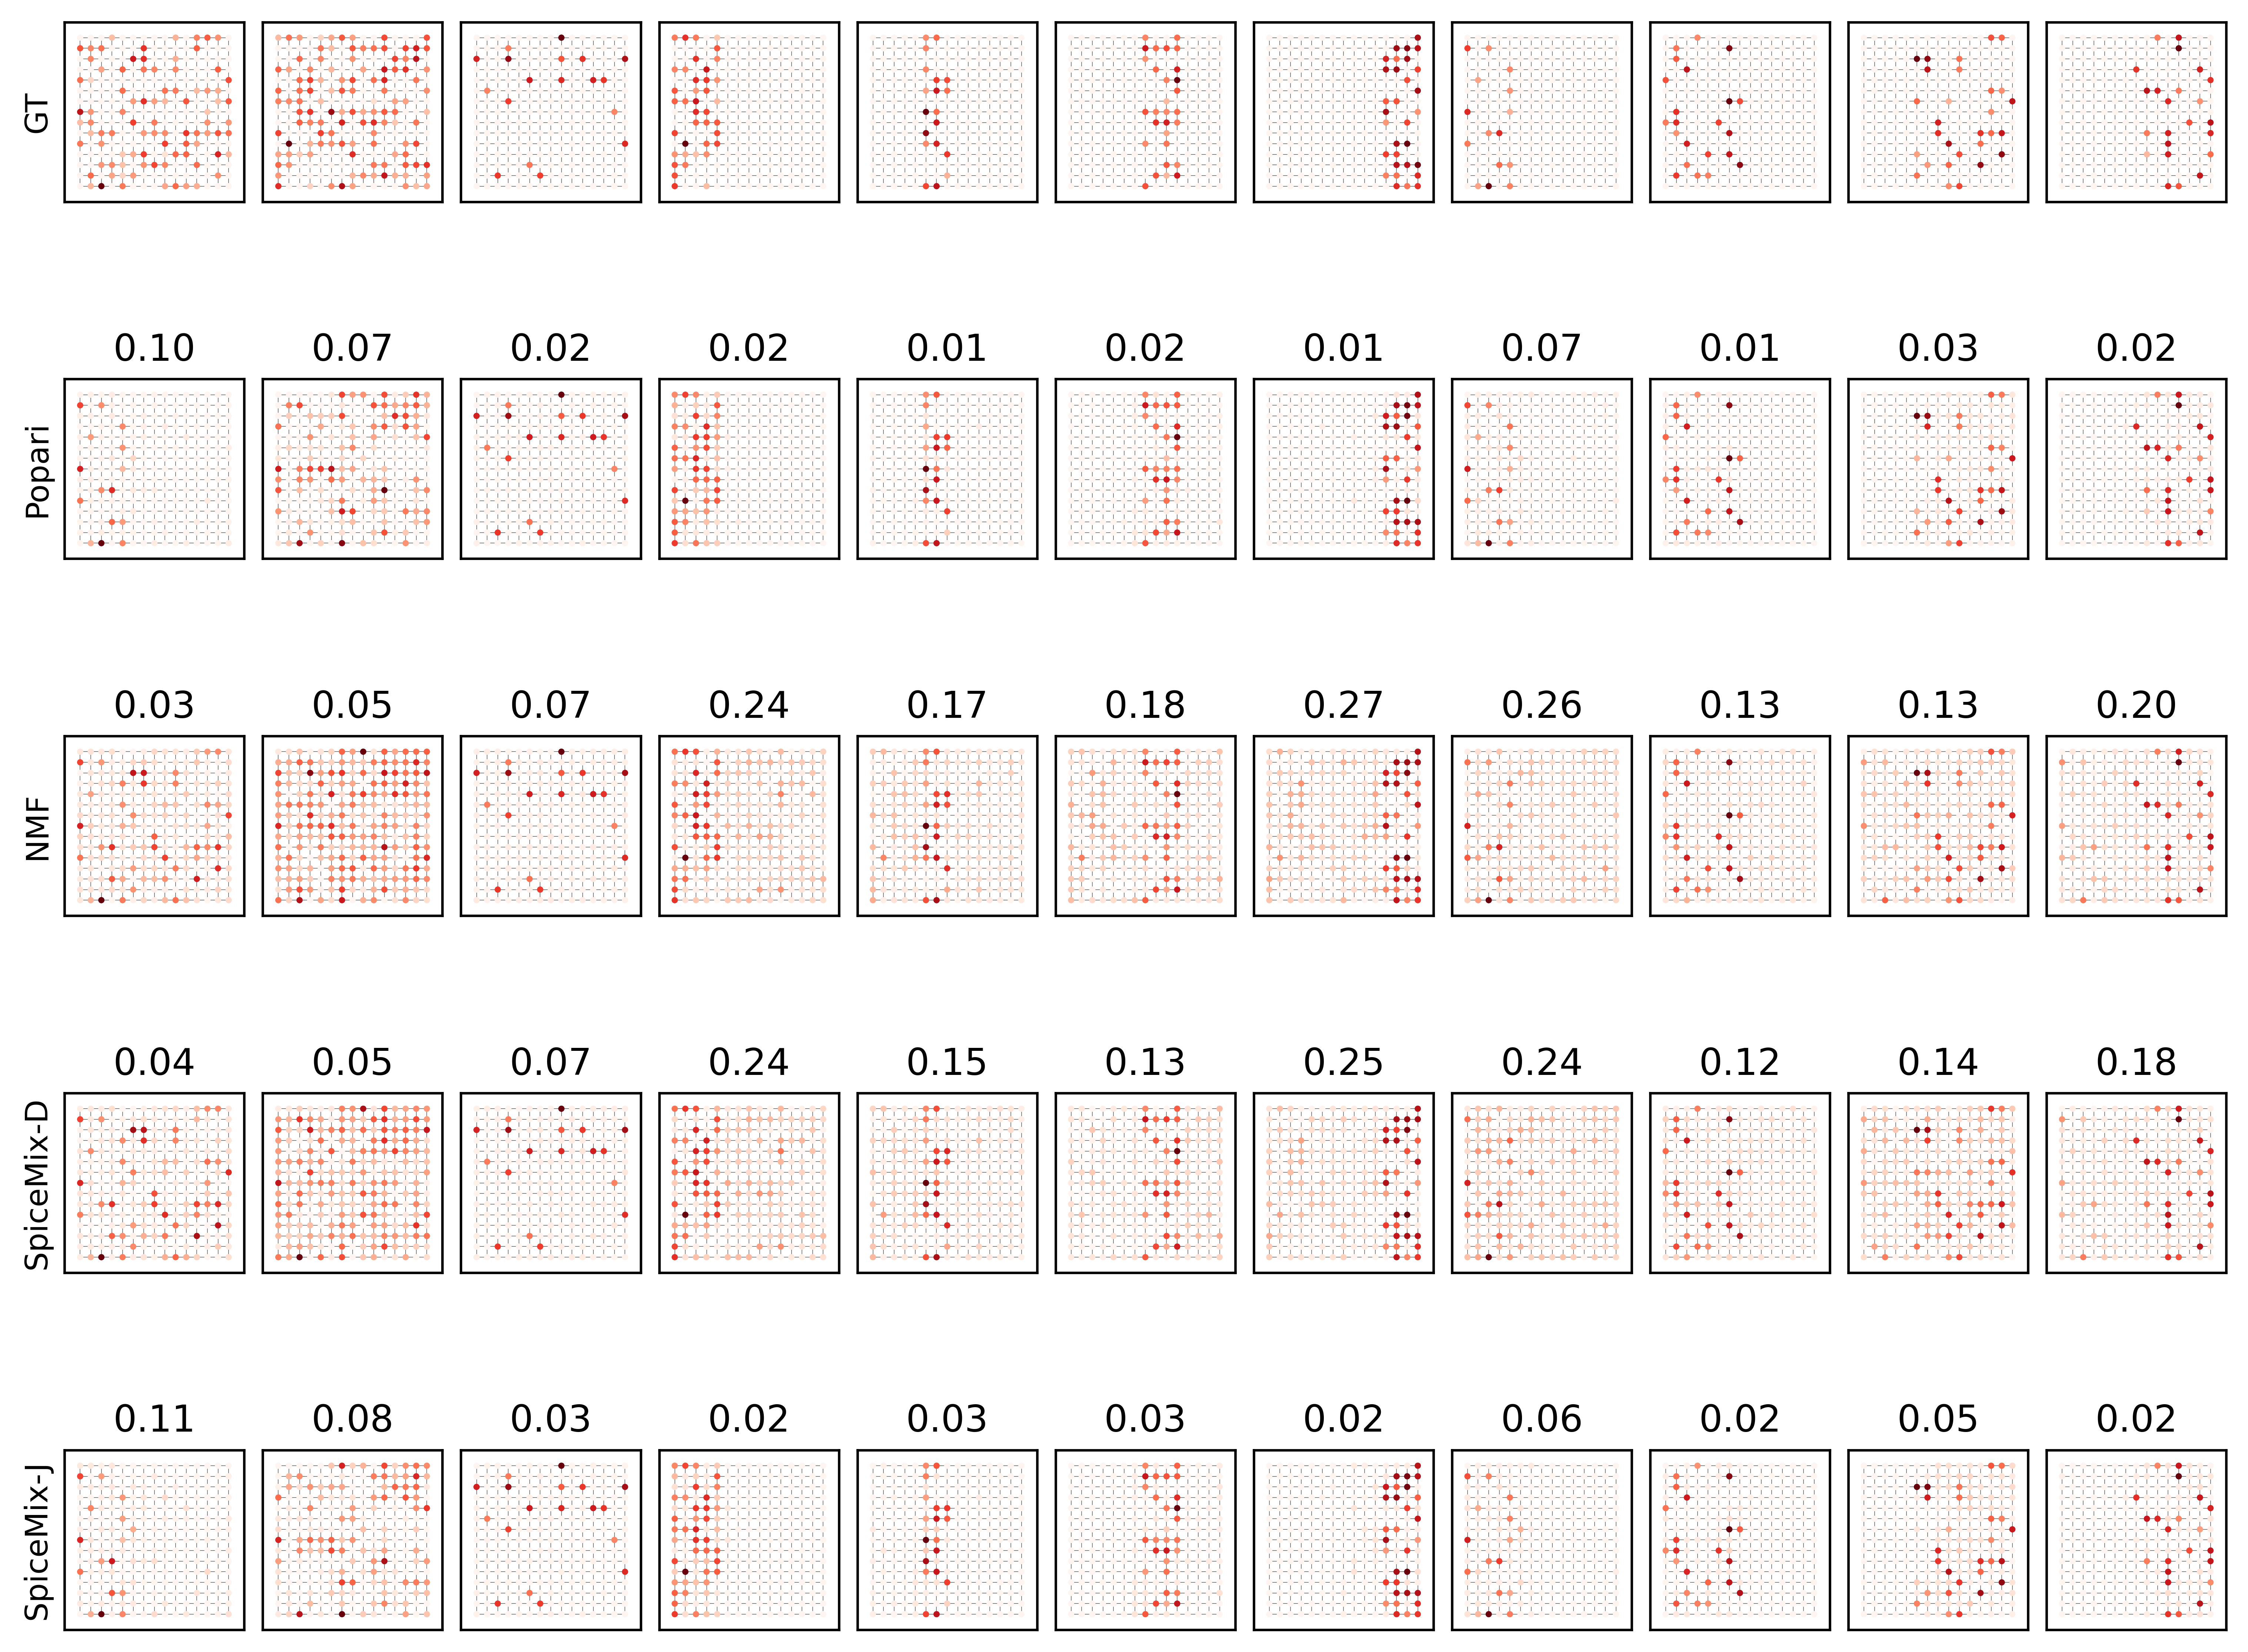

In [30]:
dataset_index = 5
in_situ_fig, best_models = _plot_best_in_situ_result(popari_evaluation, [nmf_evaluation, disjoint_spicemix_evaluation, joint_spicemix_evaluation], metagene_indices, "embedding_spatial_wasserstein_maxmin", dataset_index=dataset_index, size=7)

(1, 0)
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_stat

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2024/08/08 19:44:19]	 Initializing MetageneState
[2024/08/08 19:44:19]	 Initializing SpatialAffinityState
[2024/08/08 19:44:19]	 Initializing EmbeddingOptimizer
[2024/08/08 19:44:19]	 Initializing EmbeddingState
[2024/08/08 19:44:19]	 Reloading level 0
[2024/08/08 19:44:19]	 Initializing MetageneState
[2024/08/08 19:44:19]	 Initializing SpatialAffinityState
[2024/08/08 19:44:19]	 Initializing EmbeddingOptimizer
[2024/08/08 19:44:19]	 Initializing EmbeddingState
100
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6
random_state_5
random_state_4
random_state_3
random_state_2
random_state_1
random_state_0
random_state_19
random_state_18
random_state_17
random_state_16
random_state_15
random_state_14
random_state_13
random_state_12
random_state_11
random_state_10
random_state_9
random_state_8
random_state_7
random_state_6

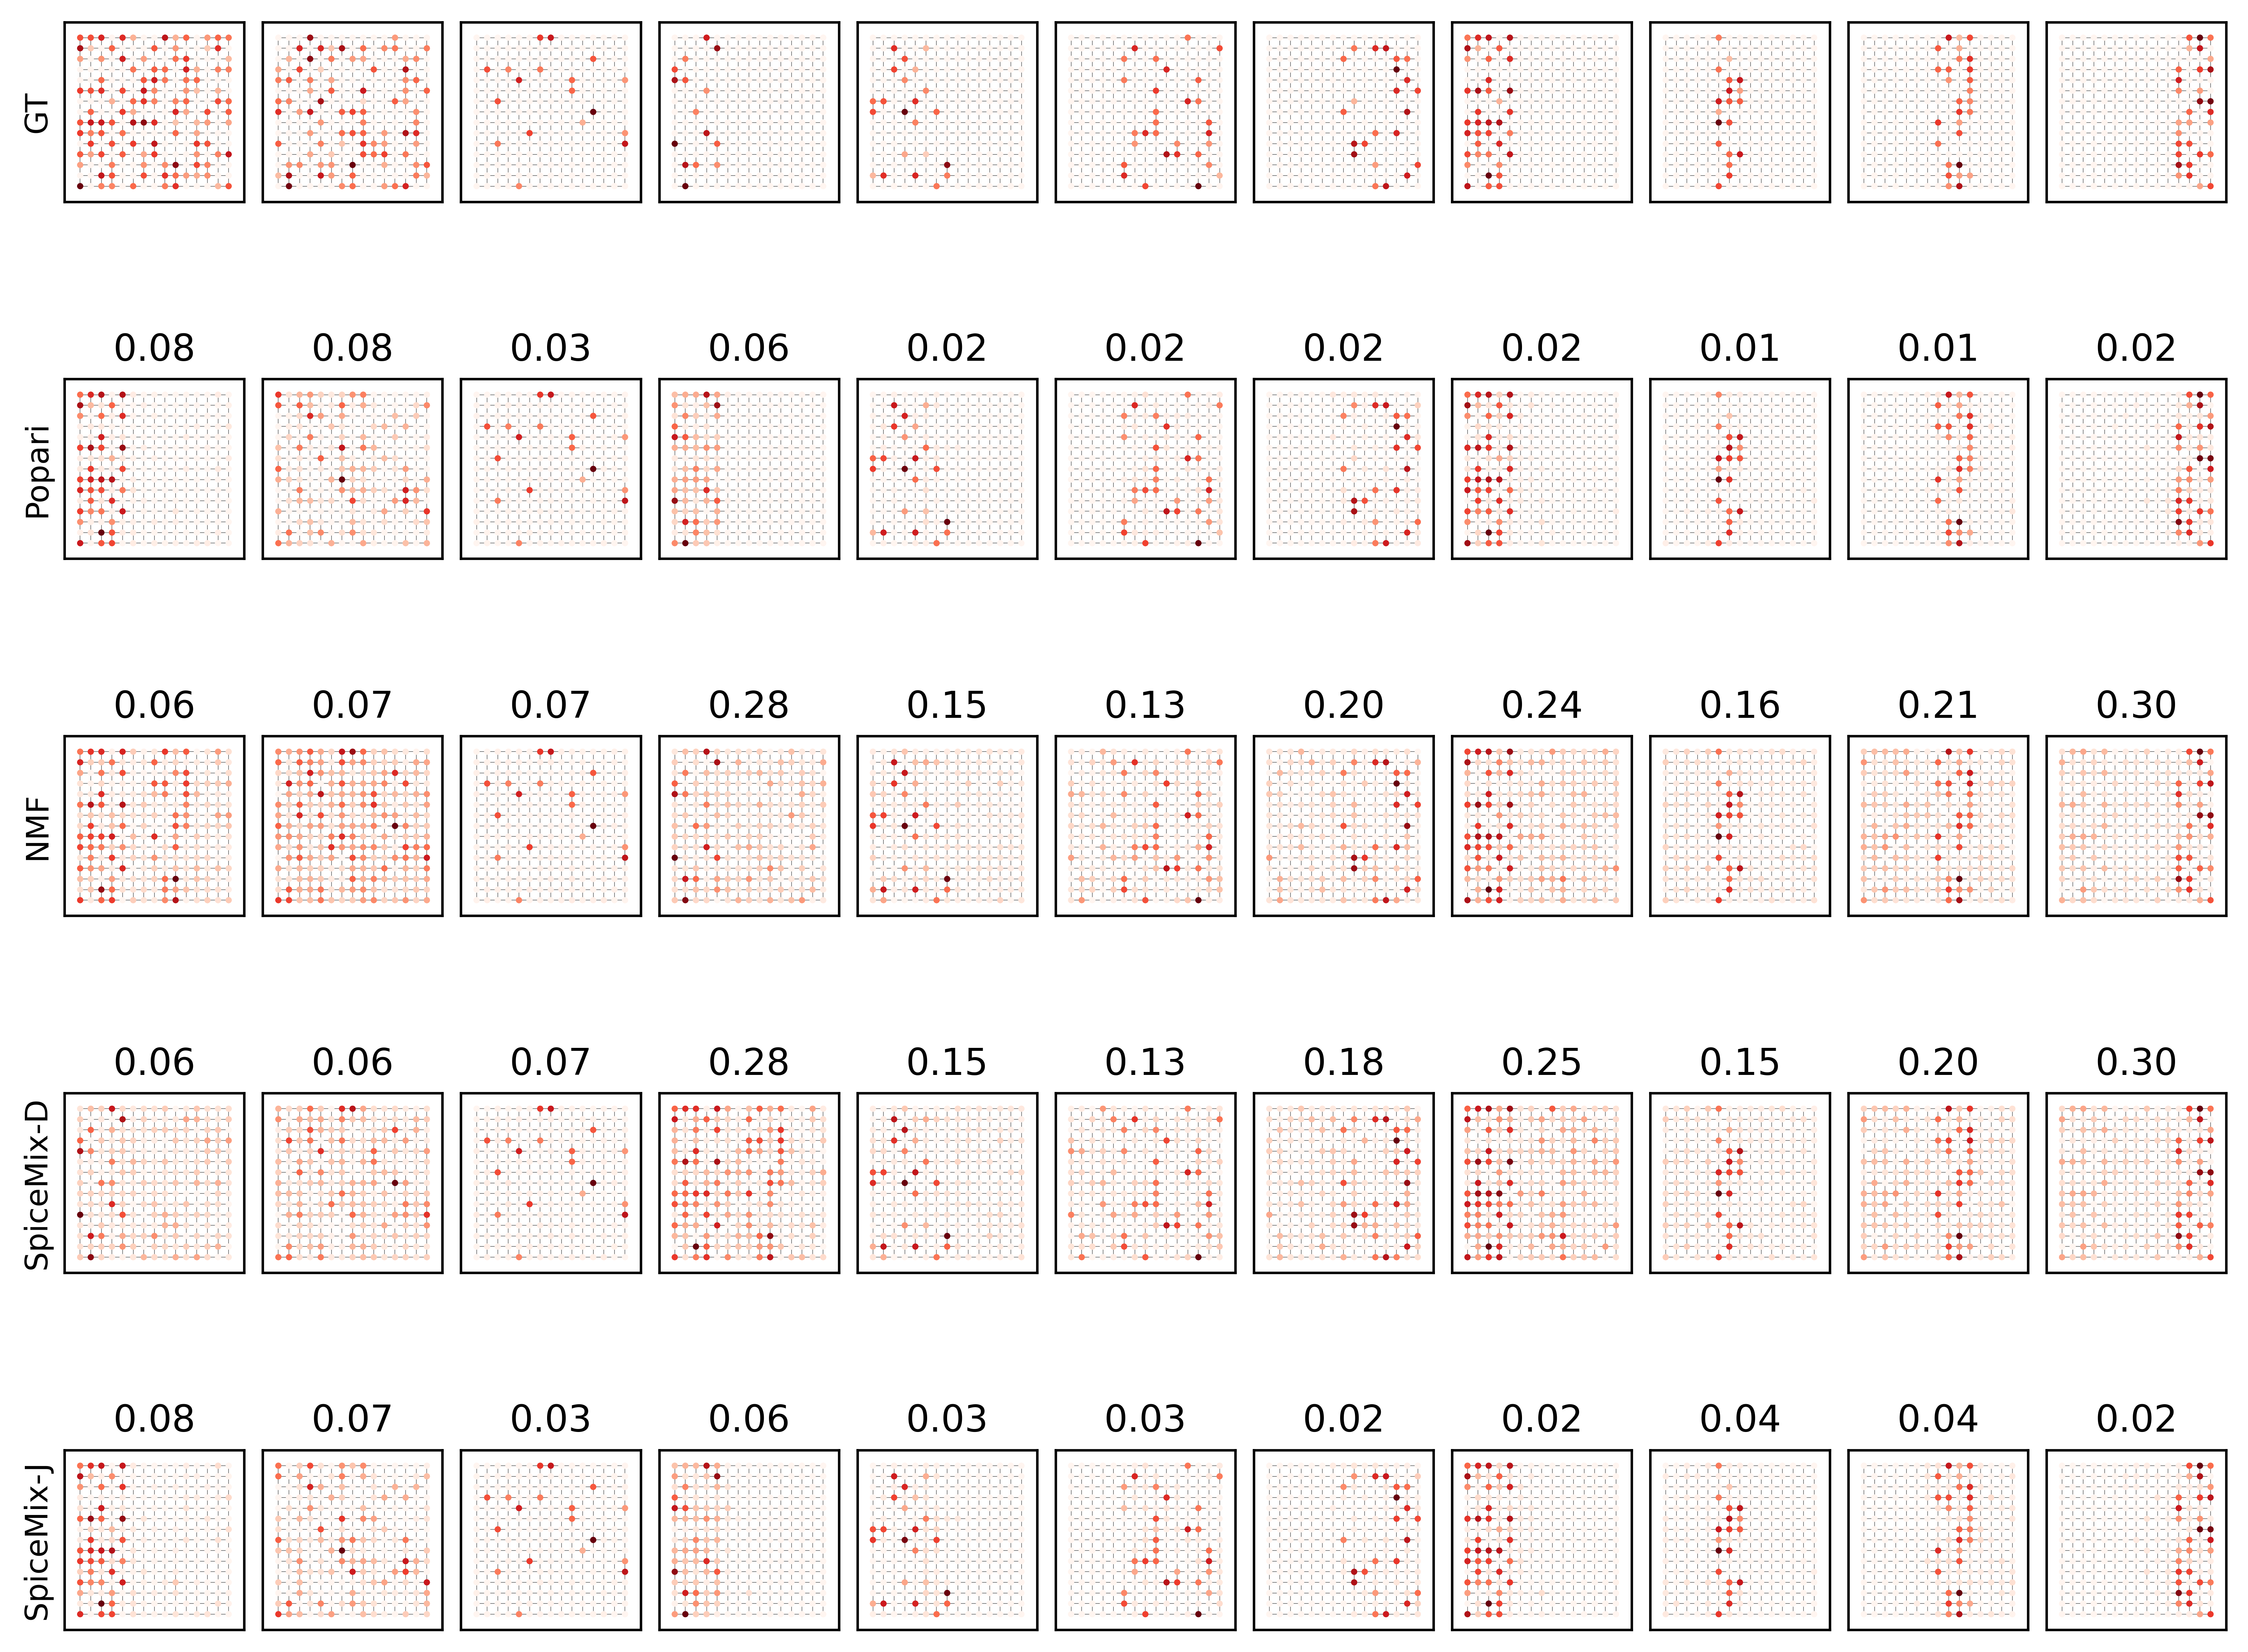

In [31]:
dataset_index = 6
in_situ_fig, best_models = _plot_best_in_situ_result(popari_evaluation, [nmf_evaluation, disjoint_spicemix_evaluation, joint_spicemix_evaluation], metagene_indices, "embedding_spatial_wasserstein_maxmin", dataset_index=dataset_index, best_models=best_models, size=7)

(1, 0)
100


/tmp/ipykernel_214396/3918739931.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones((K, K), dtype=np.bool)


SpiceMix-D
100
1.0
120.5
SpiceMix-J
100
1.0
120.5


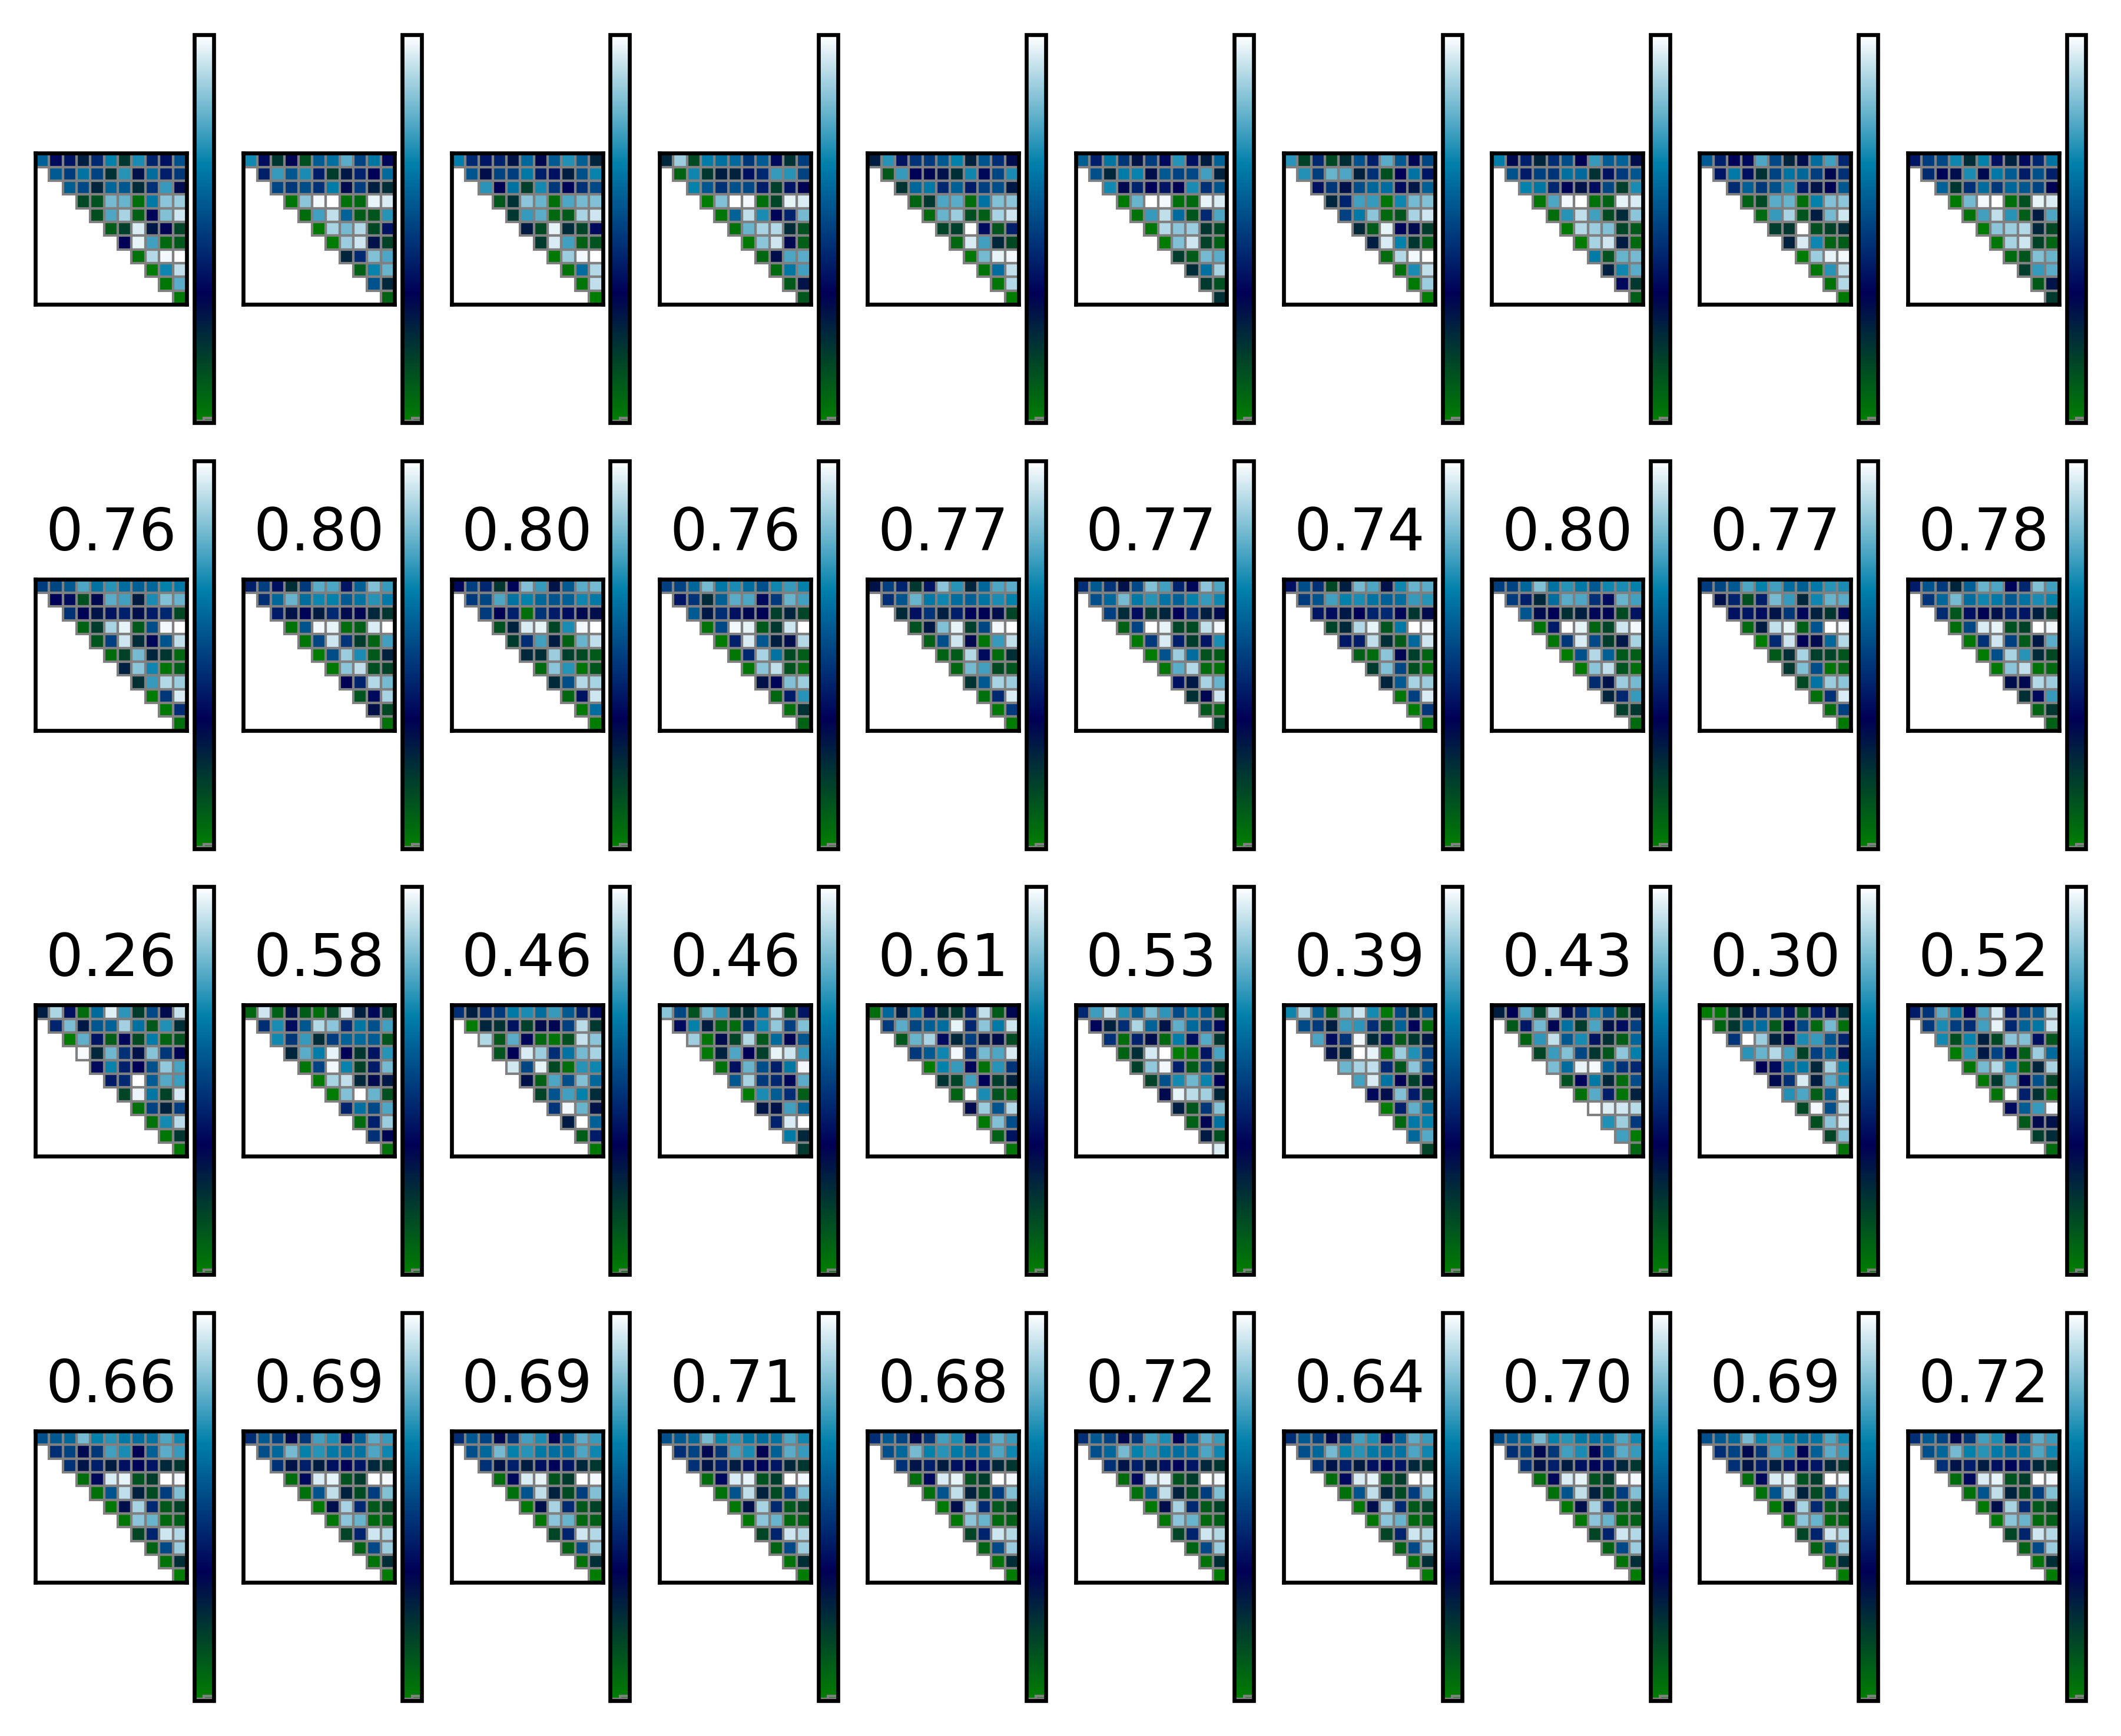

In [54]:
affinity_fig, best_models = _plot_best_affinity_correlation_result(popari_evaluation, [disjoint_spicemix_evaluation, joint_spicemix_evaluation], metagene_indices, "affinity_correlation", best_index=(1, 0), best_models=best_models, use_residuals=True)

In [33]:
in_situ_fig.savefig(figure_directory / f"joint_in_situ_dataset_{dataset_index}.pdf", transparent=True)

In [44]:
affinity_fig.savefig(figure_directory / "joint_affinity.pdf", transparent=True)

### Average values (for figure)

In [ ]:
def get_average_metric(evaluation, metric, direction, level=0):
    primary_scores = evaluation.scores[level][metric]
    primary_scores = np.array([scores for replicate_name, scores in primary_scores.items()])
    
    # Take the average score across all replicates
    primary_scores = primary_scores.mean(axis=-1)

    # Pick the best random seed for each dataset
    reduction = np.max if direction == "larger" else np.min

    primary_scores = reduction(primary_scores, axis=-1)
    
    average_metric = primary_scores.mean()

    return average_metric

In [71]:
popari_amswd = get_average_metric(popari_evaluation, "embedding_spatial_wasserstein_maxmin", "smaller")
nmf_amswd = get_average_metric(nmf_evaluation, "embedding_spatial_wasserstein_maxmin", "smaller")
disjoint_spicemix_amswd = get_average_metric(disjoint_spicemix_evaluation, "embedding_spatial_wasserstein_maxmin", "smaller")
joint_spicemix_amswd = get_average_metric(joint_spicemix_evaluation, "embedding_spatial_wasserstein_maxmin", "smaller")

In [76]:
popari_asc = get_average_metric(popari_evaluation, "affinity_correlation", "larger")
disjoint_spicemix_asc = get_average_metric(disjoint_spicemix_evaluation, "affinity_correlation", "larger")
joint_spicemix_asc = get_average_metric(joint_spicemix_evaluation, "affinity_correlation", "larger")

In [80]:
print(f"Popari average mSWD: {popari_amswd}")
print(f"NMF average mSWD: {nmf_amswd}")
print(f"Disjoint SpiceMix average mSWD: {disjoint_spicemix_amswd}")
print(f"Joint SpiceMix average mSWD: {joint_spicemix_amswd}")

Popari average mSWD: 0.09708977850094304
NMF average mSWD: 0.28625198069633756
Disjoint SpiceMix average mSWD: 0.23416902891287408
Joint SpiceMix average mSWD: 0.12746288769750946


In [81]:
print(f"Popari average ASC: {popari_asc}")
print(f"Disjoint SpiceMix average ASC: {disjoint_spicemix_asc}")
print(f"Joint SpiceMix average ASC: {joint_spicemix_asc}")

Popari average ASC: 0.7638076460524758
Disjoint SpiceMix average ASC: 0.5066831986720194
Joint SpiceMix average ASC: 0.6576589257584227


### Spatial Wasserstein Demo

In [30]:
from anndata import AnnData
from popari.simulation_framework import sample_2D_points
from popari.components import PopariDataset

import squidpy as sq
from scipy.stats import wasserstein_distance

In [52]:
rng = np.random.default_rng(seed=0)
num_points = 100

mock_coordinates = sample_2D_points(num_points, 0.05)
mock_coordinates = mock_coordinates[np.argsort(mock_coordinates[:, 0])]

mock_expression = np.zeros((num_points, 1))
metagene_expression = mock_coordinates[:, 0]
reversed_expression = mock_coordinates[::-1, 0]
rolled_expression = np.concatenate([mock_coordinates[::2, 0], mock_coordinates[1::2, 0][::-1]])

mock_dataset = AnnData(X=mock_expression)
mock_dataset.obsm["spatial"] = mock_coordinates
mock_dataset.obs["ground_truth"] = metagene_expression
mock_dataset.obs["rolled"] = rolled_expression
mock_dataset.obs["reversed"] = reversed_expression

mock_dataset = PopariDataset(mock_dataset, "mock")
mock_dataset.compute_spatial_neighbors()

In [53]:
wasserstein_distance(mock_dataset.obs["ground_truth"], mock_dataset.obs["rolled"])

0.0

In [54]:
wasserstein_distance(mock_dataset.obs["ground_truth"], mock_dataset.obs["reversed"])

0.0

In [55]:
spatial_wasserstein(mock_dataset.obsm["spatial"], mock_dataset.obs["ground_truth"], mock_dataset.obs["rolled"])

0.1436856808255641

In [56]:
spatial_wasserstein(mock_dataset.obsm["spatial"], mock_dataset.obs["ground_truth"], mock_dataset.obs["reversed"])

0.3154823051204019

In [57]:
spatial_wasserstein(mock_dataset.obsm["spatial"], mock_dataset.obs["ground_truth"], mock_dataset.obs["ground_truth"])

0

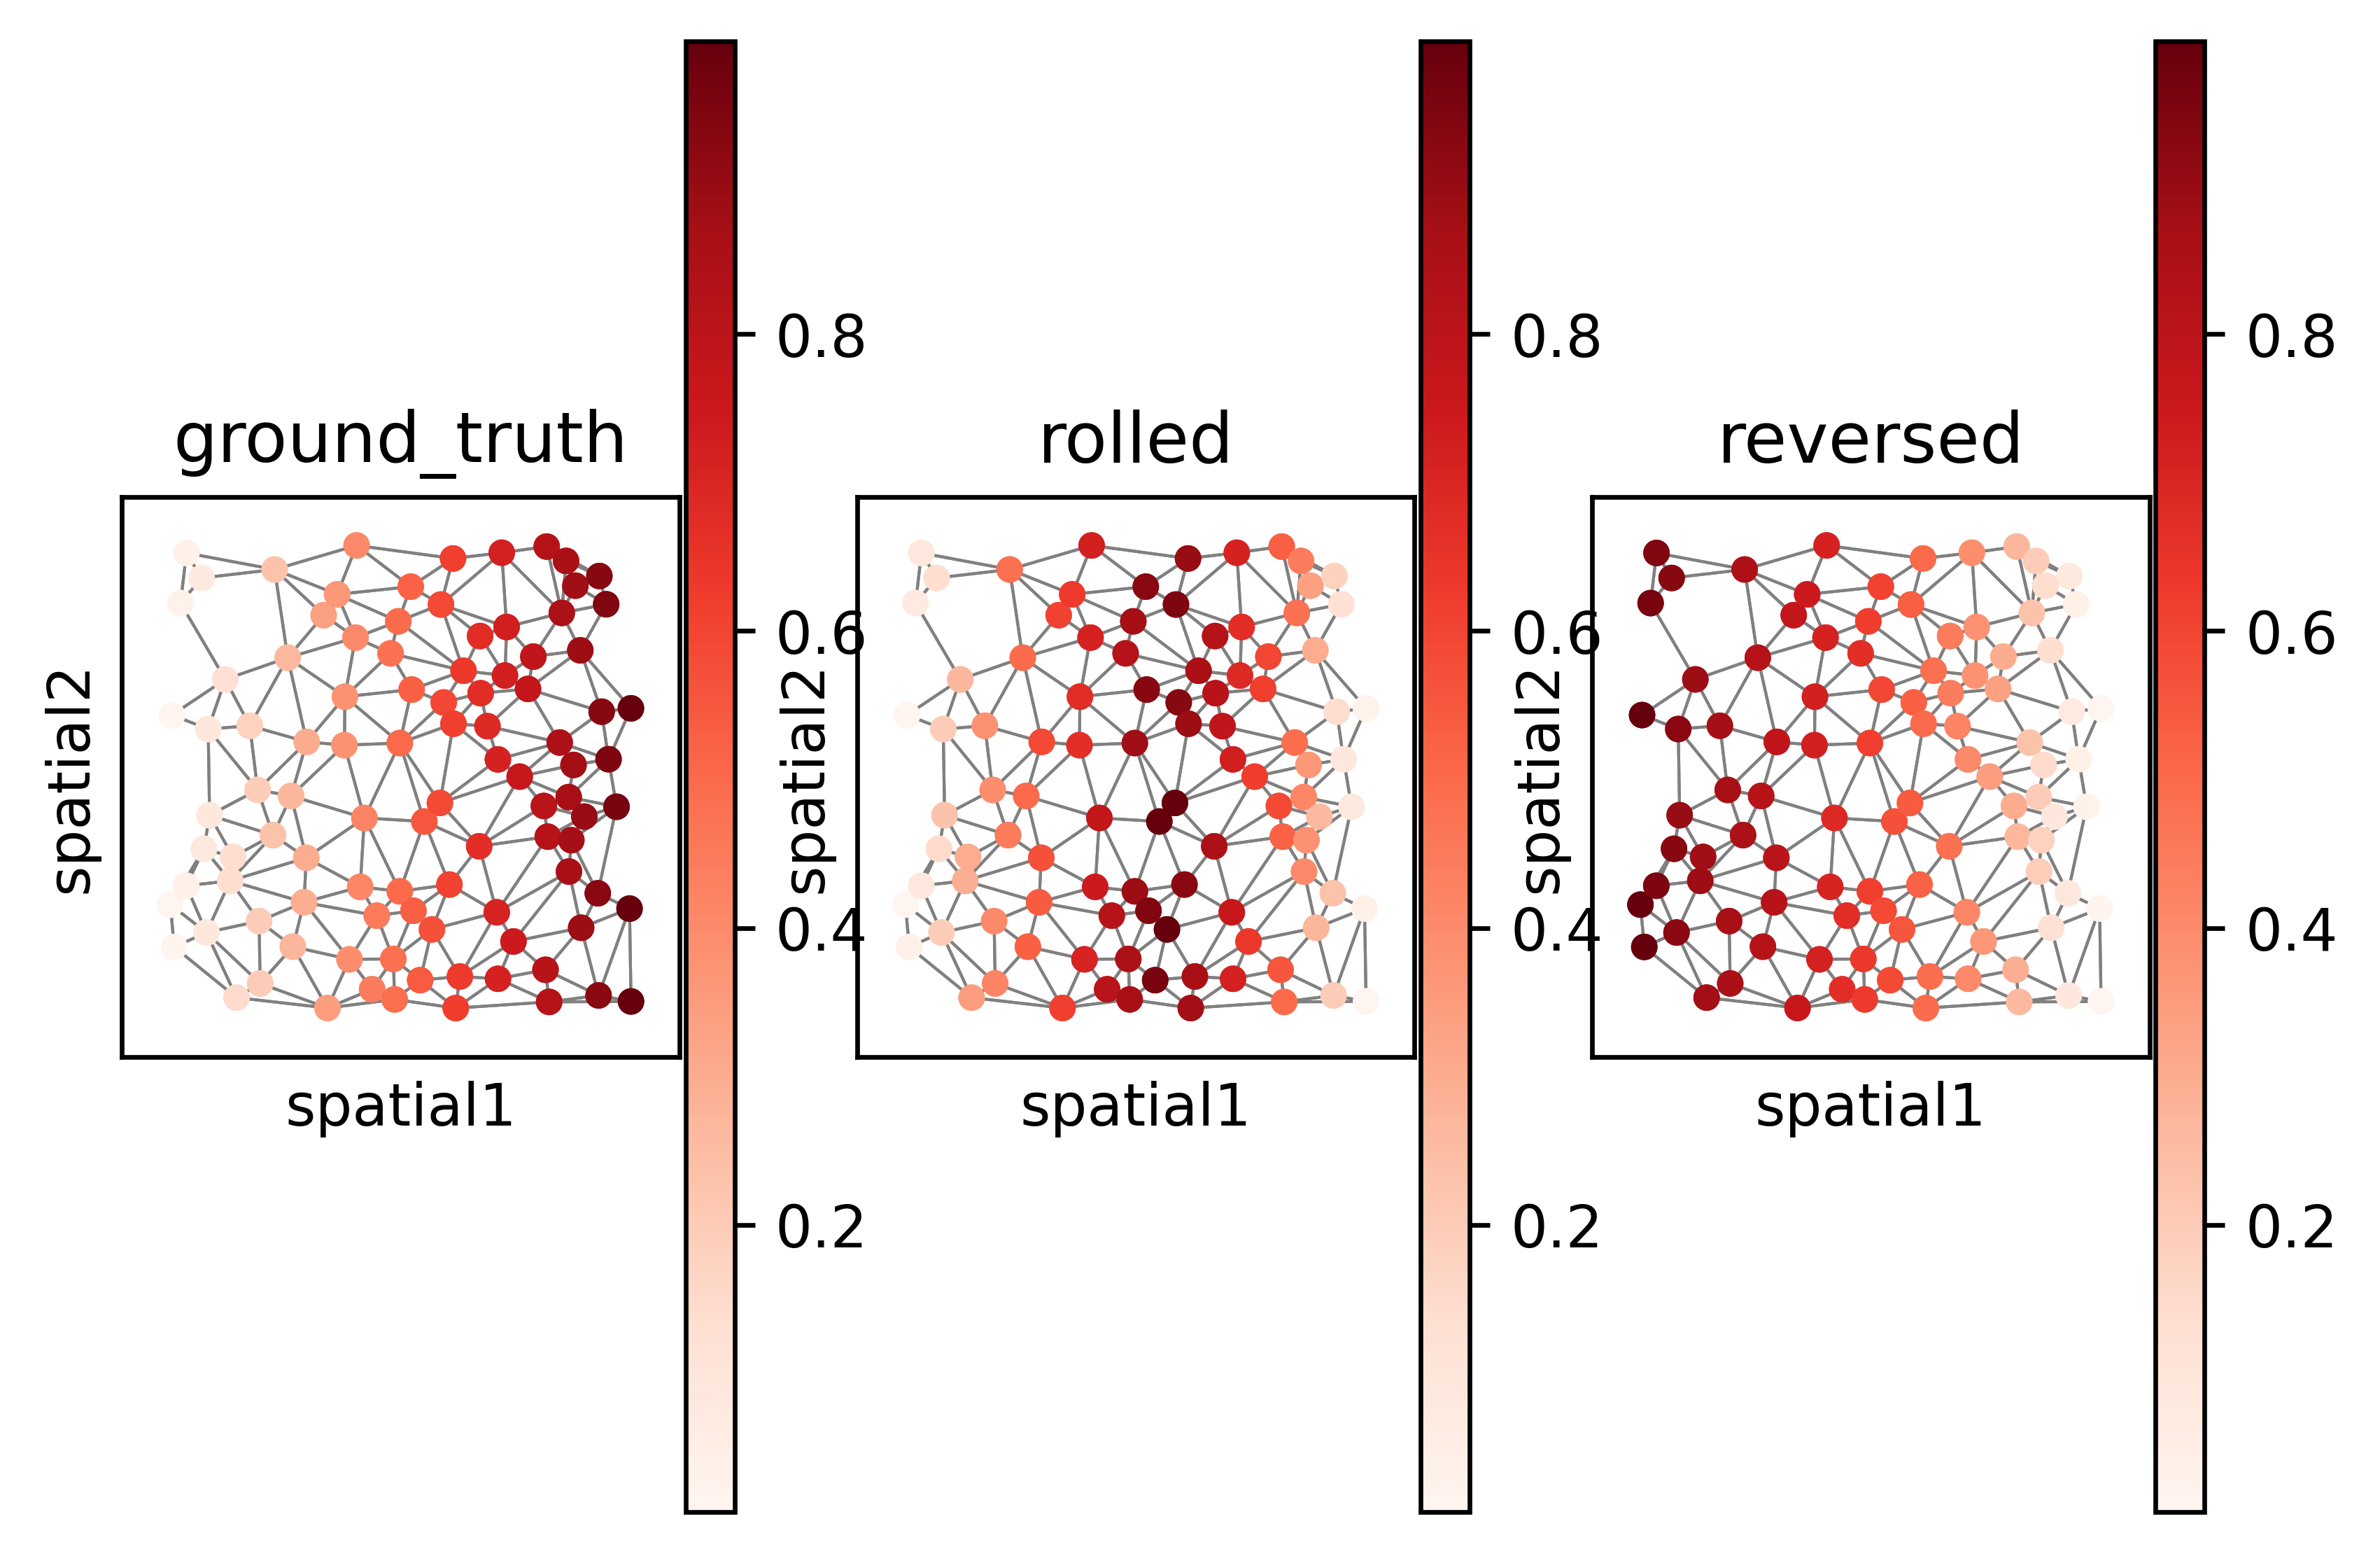

In [58]:
mock_ground_truth_in_situ_fig, axes = plt.subplots(1, 3, dpi=600)
sq.pl.spatial_scatter(mock_dataset,
                      color=["ground_truth", "rolled", "reversed"],
                      connectivity_key="adjacency_matrix",
                      size=50,
                      cmap="Reds",
                      edges_width=0.5,
                      shape=None,
                      ax=axes,
                      fig=mock_ground_truth_in_situ_fig
                     )

In [59]:
mock_ground_truth_in_situ_fig.savefig(figure_directory / "mock_ground_truth.pdf", transparent=True)